## Laboratory work 3
<b>NN architecture:</b> Xception and WideResNet <br>
<b>Dataset:</b> Cifar10 <br>
<b>link to dataset:</b> https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The <b>CIFAR-10</b> dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics
import random
import math
import gc

from sklearn.model_selection import StratifiedKFold, train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_test = torch.Generator().manual_seed(1)

In [4]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
rand_const = 0

## Data read
This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). Let's further split it into:
```
1. train set           66.6%       40000 images
2. validation set      16.7%       10000 images
3. test set            16.7%       10000 images
Total images used for sets: 60000
```

In [5]:
train_set_img_cnt = 40000
valid_set_img_cnt = 10000
test_set_img_cnt = 10000

### Define transformers for data

In [6]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> resize to image_size x image_size -> 
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std
image_size = 299
transform_train = transforms.Compose([
    transforms.Resize(image_size),     # NOT USED IN CASE OF WideResNet!
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),     # NOT USED IN CASE OF WideResNet!
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Clear memory
del traindata
del testdata
gc.collect()

100%|██████████| 170498071/170498071 [00:04<00:00, 35069817.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


30

### Creating dataloaders for train, validation and test datasets

In [7]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

labels = trainset.targets

# Perform stratified random split into training (70%) and validation (30%) sets
train_indexes, val_indexes = train_test_split(list(range(len(trainset))), test_size=0.2, random_state=rand_const, stratify=labels)

# Create train and validation datasets
train_dataset = torch.utils.data.Subset(trainset, train_indexes)
val_dataset = torch.utils.data.Subset(trainset, val_indexes)

# Create a sampler, that provides an iterable over the train and validation sets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

In [10]:
# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Create a sampler for testset
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

### Data visualization

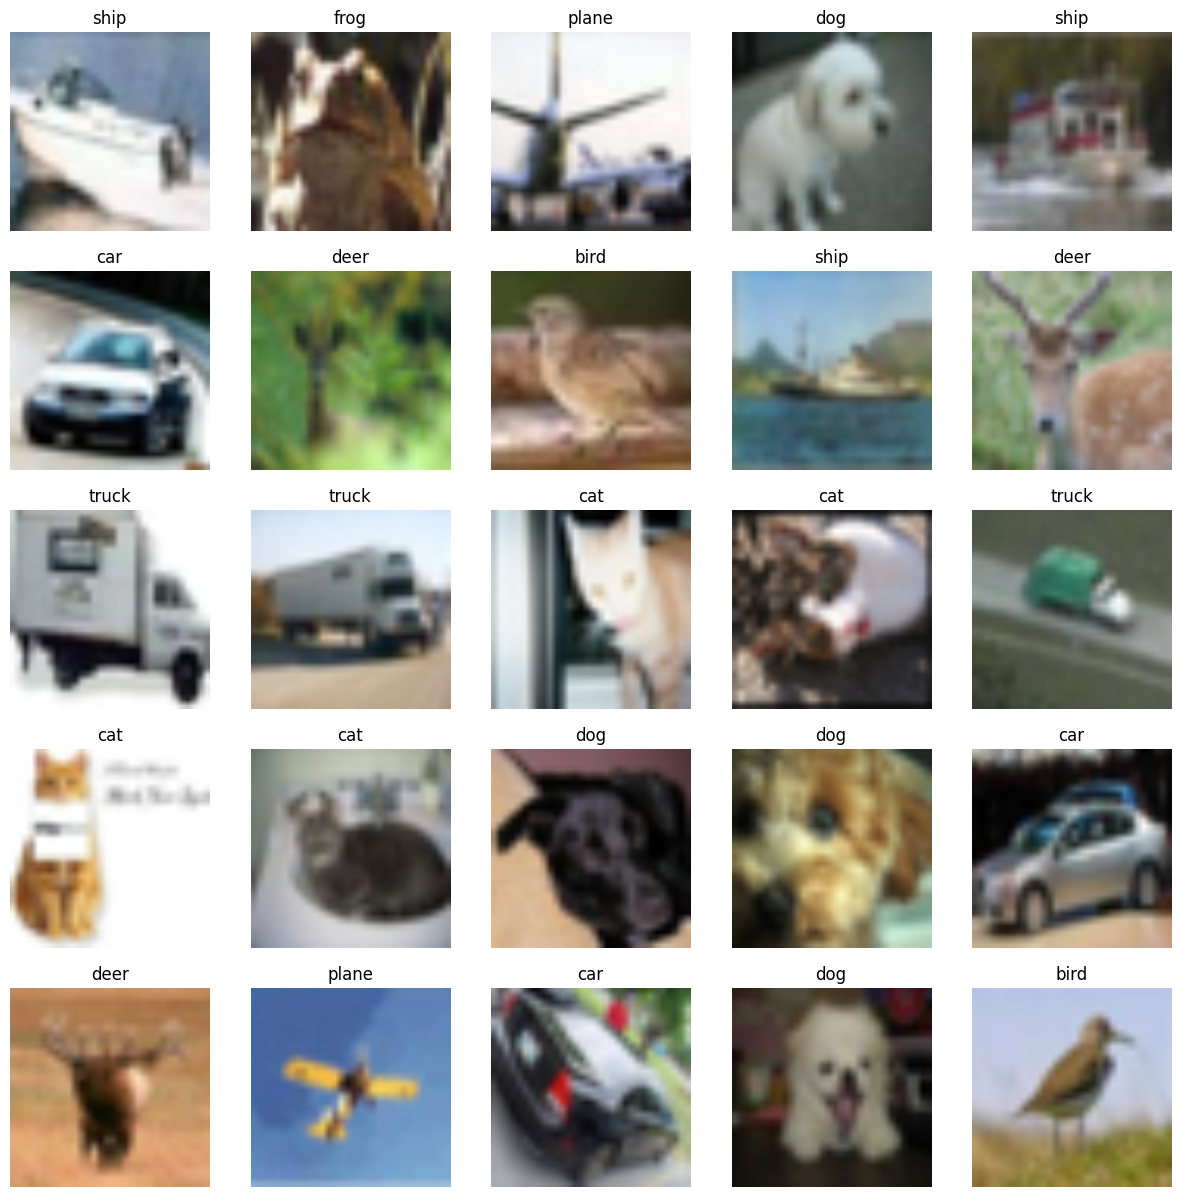

In [8]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [11]:
train_batches_num = len(train_loader)
val_batches_num = len(val_loader)
test_batches_num = len(test_loader)
print(f"Amount of batches processed in each epoch during full training: {train_batches_num}")

Amount of batches processed in each epoch during full training: 1250


In [12]:
# Set up loss criterion
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)

### We won't use cross-validation and grid-search for hyperparameter tuning due to the fact that training the network requires many computational time even without these techniques. In this notebook training from specific checkpoints are displayed because due to many epochs required model was trained several times starting from previous progress.

## Class, that creates abstraction for model, dataloaders, optimizer, criterion, etc., and allows to train, validate and test this model

In [13]:
class ModelCycles:
    def __init__(self, model, optimizer, criterion, accuracy, train_loader, val_loader, test_loader, device, best_accuracy):
        """
        Parameters
        ----------
        train_loader :
            Batch loader of train data
        val_loader :
            Batch loader of validation data
        test_loader :
            Batch loader of test data
        device :
            Device where data will be sent to (for example cuda)
        """

        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.accuracy = accuracy
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.train_batches_num = len(train_loader)
        self.val_batches_num = len(val_loader)
        self.test_batches_num = len(test_loader)
        self.best_accuracy = best_accuracy
        
    def train_validate_cycle(self, epochs, cycle_batch, cycle_epoch):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_batch : 
            The number that determines after which amount of batches in each epoch information will be displayed
        cycle_epoch :
            The number that determines after which amount of epochs information will be displayed
        """
        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        self.train_loss_arr = np.zeros(epochs)
        self.val_loss_arr = np.zeros(epochs)
        self.val_accuracy_arr = np.zeros(epochs)

        # Create training and validation loop
        for epoch in range(epochs):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_acc = val_loss = 0
            # Set network to train mode
            self.model.train()

            # Add a loop through training batches
            for batch_num, (tr_inputs, tr_labels) in enumerate(self.train_loader):
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(device)
                tr_labels = tr_labels.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                outputs = self.model(tr_inputs).to(device)
                loss = self.criterion(outputs, tr_labels)
                loss.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss

                # Print out how many samples have been seen
                # Save loss each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * batch_size} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del tr_labels
                del outputs
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.val_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    predictions = self.model(val_inputs).to(device)

                    # Test loss and accuracy calculation
                    val_loss += self.criterion(predictions, val_labels)
                    val_acc += self.accuracy(predictions.argmax(dim=1), val_labels)

                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del predictions
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr[epoch] = train_loss / self.train_batches_num
                self.val_loss_arr[epoch] = val_loss / self.val_batches_num
                self.val_accuracy_arr[epoch] = val_acc / self.val_batches_num
                
                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average validation loss: {self.val_loss_arr[epoch]:.5f}, Average validation acc: {self.val_accuracy_arr[epoch]:.2f}%\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                if self.best_accuracy < self.val_accuracy_arr[epoch]:
                    torch.save(self.model.state_dict(), f'{type(self.model).__name__}_checkpoint.pth')
                    print(f"Epoch {epoch + 1}: checkpoint saved\n")
                    self.best_accuracy = self.val_accuracy_arr[epoch]

            gc.collect()
            torch.cuda.empty_cache()
            
    
    def model_test(self):
        test_loss = test_acc = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.test_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                predictions = self.model(test_inputs).to(device)

                # Test loss and accuracy calculation
                test_loss += self.criterion(predictions, test_labels)
                test_acc += self.accuracy(predictions.argmax(dim=1), test_labels)

                # Clearing memory
                del test_inputs
                del test_labels
                del predictions
        ##### Test end #####

            # Save average (throughout the epoch) loss and accuracy
            test_loss_score = test_loss / self.test_batches_num
            test_accuracy_score = test_acc / self.test_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_loss_score, test_accuracy_score
    
    @staticmethod
    def plot_loss_acc(epochs, train_loss_arr, val_loss_arr, val_accuracy_arr):
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, epochs + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, train_loss_arr, 'r', label='Average train loss')
        plt.plot(epoch_arr, val_loss_arr,'b', label='Average validation loss')
        plt.title("Average loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, val_accuracy_arr, 'b')
        plt.title("Average validation accuracy")
        plt.xlabel("Epoch number")
        plt.ylabel("Validation accuracy value")
        plt.show()

# Xception

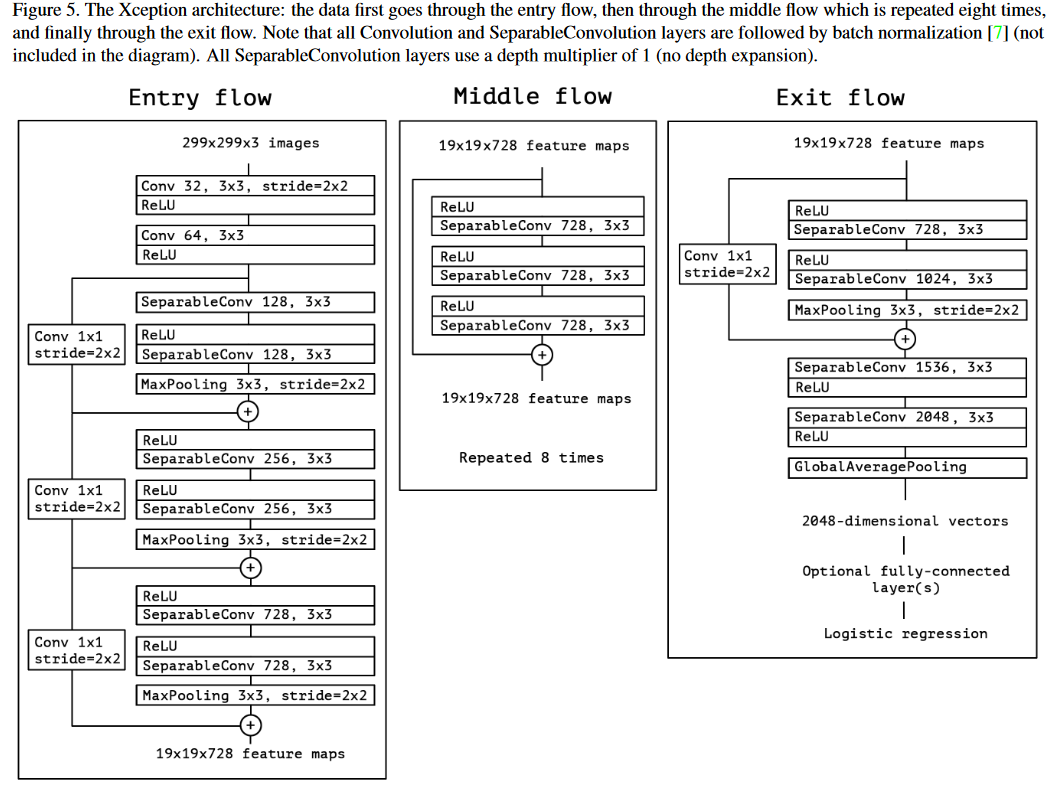

In [14]:
# Define Depth-wise separable convolution class
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        # Invoke nn.Module constructor
        super(SeparableConv2d,self).__init__()
        
        # Layer, which applies a depthwise convolution (grouped convolution with groups=in_channels),
        # where each input channel has its own convolutional kernel.
        self.depth_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        # Perform pointwise InCh X 1 X 1 convolution
        # groups=1, all inputs are convolved to all outputs.
        self.pointwise_conv = nn.Conv2d(in_channels,out_channels, kernel_size=1, stride=1, padding=0, dilation=1, groups=1,bias=bias)
    
    def forward(self,x):
        x = self.depth_conv(x)
        x = self.pointwise_conv(x)
        return x

# When using batch normalization we can turn off bias: https://arxiv.org/abs/1502.03167 
    
# Define residual block class
class ResidBlock(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        # Invoke nn.Module constructor
        super(ResidBlock, self).__init__()

        # If strides are not 1 we add convolution and batch normalization to the residual block
        # strides value are the same for convolution and MaxPooling in the inner block
        if strides!=1:
            self.resid = nn.Sequential(
                nn.Conv2d(in_filters, out_filters, kernel_size=1, stride=strides, bias=False),
                nn.BatchNorm2d(out_filters))
        else:
            self.resid=None
        
        self.relu = nn.ReLU(inplace=True)
        
        ##### Inner block #####
        
        inner=[]
        filters=in_filters
        
        # All residual blocks exept the last one in Exit flow perform
        # in_filters -> out_filters Depth-wise separable convolution first
        # padding=1 for same output with kernel_size=3
        if grow_first:
            inner.append(self.relu)
            inner.append(SeparableConv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, bias=False))
            inner.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            inner.append(self.relu)
            inner.append(SeparableConv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False))
            inner.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            inner.append(self.relu)
            inner.append(SeparableConv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, bias=False))
            inner.append(nn.BatchNorm2d(out_filters))

        # We don't start with ReLU in the first block in the Entry flow
        if not start_with_relu:
            inner = inner[1:]
        else:
            inner[0] = nn.ReLU(inplace=False)
            
        if strides != 1:
            inner.append(nn.MaxPool2d(kernel_size=3, stride=strides, padding=1))
        
        # Convert inner block to nn.Sequential
        self.inner = nn.Sequential(*inner)
        ##### Inner block END #####

    def forward(self, x):
        out = self.inner(x)

        if self.resid is not None:
            return out + self.resid(x)
        else:
            return out + x

# Xception network class
class Xception(nn.Module):
    def __init__(self, num_classes=10):
        """ Constructor
        Args:
            num_classes: number of classes, default is 10 for CIFAR-10 dataset
        """
        # Invoke nn.Module constructor
        super(Xception, self).__init__()

        self.num_classes = num_classes

        self.entry_flow = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            ResidBlock(64,128,2,2,start_with_relu=False,grow_first=True),
            ResidBlock(128,256,2,2,start_with_relu=True,grow_first=True),
            ResidBlock(256,728,2,2,start_with_relu=True,grow_first=True))

        self.middle_flow = nn.Sequential(
            *[ResidBlock(728, 728, 3, 1, start_with_relu=True, grow_first=True) for _ in range(8)]
        )

        self.exit_flow = nn.Sequential(
            ResidBlock(728,1024,2,2,start_with_relu=True,grow_first=False),
            SeparableConv2d(1024,1536,3,1,1),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            SeparableConv2d(1536,2048,3,1,1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True))

        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
            nn.Softmax(dim=1))

        #------- init weights --------
        for module in self.modules():
            # Initialize ordinary convolution weigths with N(0, sqrt(2/(kernel_elements*out_channels)))
            if isinstance(module, nn.Conv2d):
                n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
                module.weight.data.normal_(0, math.sqrt(2. / n))
            # Initialize batch normalization weigths with 1 and bias as 0
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1) # no scale
                module.bias.data.zero_() # no shift
        #-----------------------------

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = F.adaptive_avg_pool2d(input=x, output_size=(1, 1)) # perform Average pooling NxCxHxW -> NxCx1x1
        x = x.view(x.size(0), -1) # flatten to N x 2048
        x = self.classifier(x)
        return x

In [18]:
# Set up stohastic gradient descent method with
# learning rate = 0.001
# momentum = 0.9
xception_nn = Xception().to(device)
optimizer = optim.SGD(xception_nn.parameters(), lr=0.001, momentum=0.9)

# Load 12 epoch checkpoint
xception_nn.load_state_dict(torch.load('/kaggle/input/cv-tasks-lab3-data/Xception_12epoch.pth'))
# Arrays that store loss and accuracy calculated during 12 epoch training
train_loss_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/Xception_train_loss_arr_12.npy')
val_loss_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/Xception_val_loss_arr_12.npy')
val_accuracy_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/Xception_val_accuracy_arr_12.npy')

In [19]:
# allows to go through train-validation loops and perform test
xception_nn_model_cycle = ModelCycles(xception_nn, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device, np.max(val_accuracy_arr_pretr))

In [29]:
# train for 5 more epochs
xception_nn_model_cycle.train_validate_cycle(5, 400, 1)

Current epoch: 1
-------
Looked at 12768 samples
Current train loss for batch: 1.6658644676208496
Looked at 25568 samples
Current train loss for batch: 1.7066978216171265
Looked at 38368 samples
Current train loss for batch: 1.607988953590393

Average train loss: 1.66848
Average validation loss: 1.70220, Average validation acc: 0.76%

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 1.6580780744552612
Looked at 25568 samples
Current train loss for batch: 1.5967106819152832
Looked at 38368 samples
Current train loss for batch: 1.6786975860595703

Average train loss: 1.65431
Average validation loss: 1.68034, Average validation acc: 0.79%

Epoch 2: checkpoint saved

Current epoch: 3
-------
Looked at 12768 samples
Current train loss for batch: 1.685078740119934
Looked at 25568 samples
Current train loss for batch: 1.596372127532959
Looked at 38368 samples
Current train loss for batch: 1.5510287284851074

Average train loss: 1.64107
Average validation loss: 1.

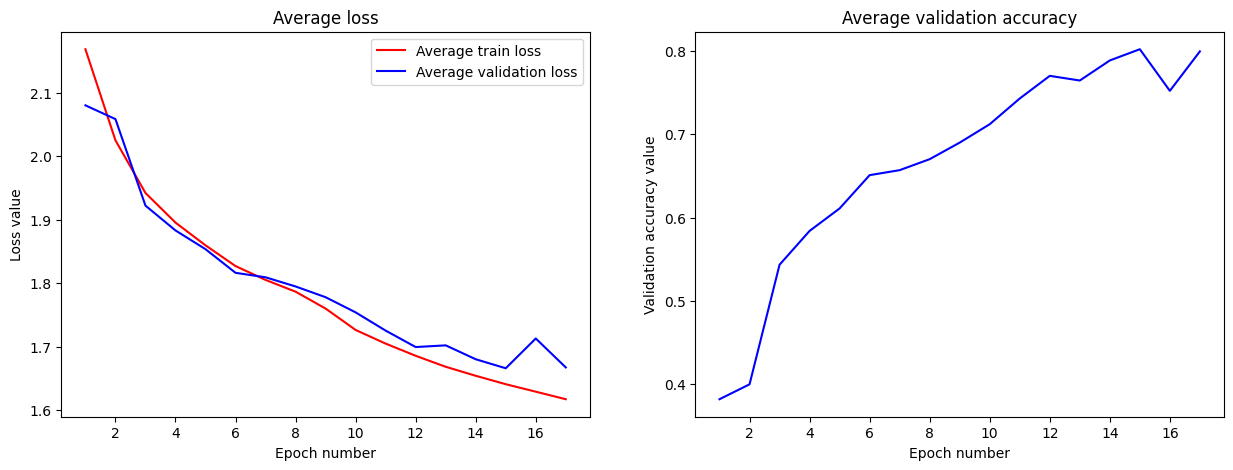

In [30]:
train_loss_arr = np.concatenate((train_loss_arr_pretr, xception_nn_model_cycle.train_loss_arr))
val_loss_arr = np.concatenate((val_loss_arr_pretr, xception_nn_model_cycle.val_loss_arr))
val_accuracy_arr = np.concatenate((val_accuracy_arr_pretr, xception_nn_model_cycle.val_accuracy_arr))
ModelCycles.plot_loss_acc(17, train_loss_arr, val_loss_arr, val_accuracy_arr)

## As we can see, approximately at the epoch 16 overfit started, so we will use checkpoint from epoch 15 as our best model. Let's check results of our models on test set:

In [31]:
# Save checkpoint
# torch.save(xception_nn.state_dict(), 'Xception_12epoch.pth')
# To load weigths:
# xception_nn.load_state_dict(torch.load('/kaggle/input/cv-tasks-lab3-data/Xception_<epoch_num>epoch.pth'))
# xception_nn.eval()
np.save('train_loss_arr_17.npy', train_loss_arr)
np.save('val_loss_arr_17.npy', val_loss_arr)
np.save('val_accuracy_arr_17.npy', val_accuracy_arr)

In [20]:
xception_nn = Xception().to(device)
xception_nn.load_state_dict(torch.load('/kaggle/input/cv-tasks-lab3-data/Xception_checkpoint_17(best).pth'))
xception_nn_model_cycle.model = xception_nn
test_loss_score, test_accuracy_score = xception_nn_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 1.6692808866500854
Test accuracy: 0.7973242402076721


# WideResNet

## BasicBlock on the left and Bottleneck on the right:
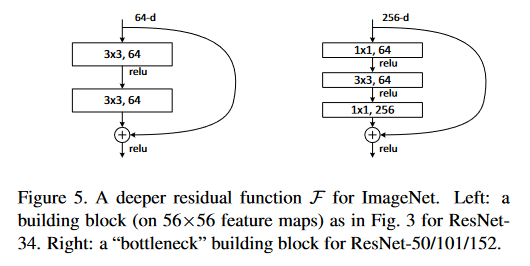

## ResNet architecture:

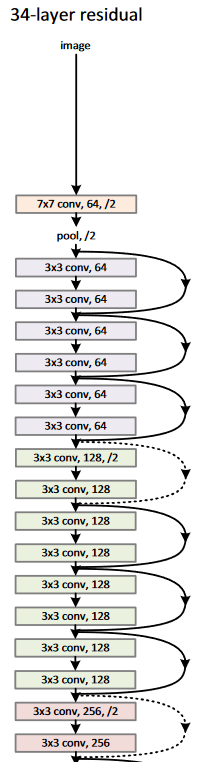
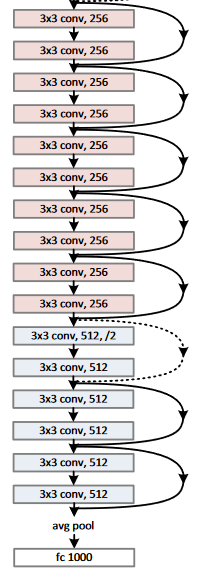

## WideResNet architecture:

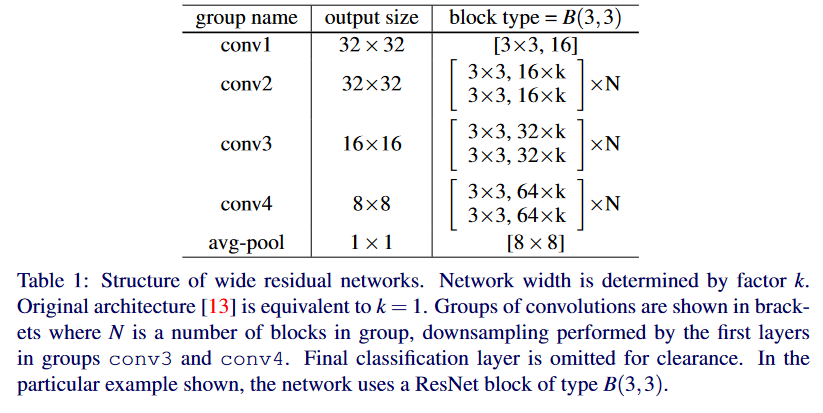
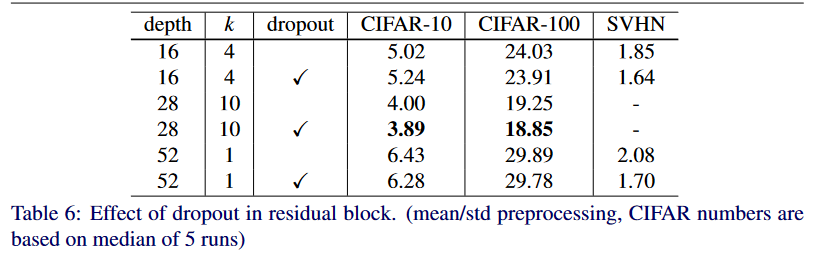
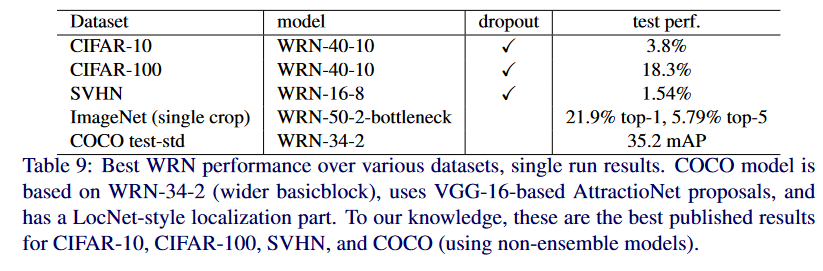

In [41]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(BasicBlock, self).__init__()
        # First convolution
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # Second convolution
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.dropout = dropout
        self.is_first_block = (in_channels != out_channels) # Whether it's a first block in a group
        self.dim_handler = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False), # 1x1 convolution
            nn.BatchNorm2d(out_channels)) # batch normalization
        
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.dropout > 0:
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        
        # If it's a first block in a group we need to handle difference in dimensions
        # between residual connection and output
        return torch.add(self.dim_handler(x) if self.is_first_block else x, out)

class WRNGroup(nn.Module):
    def __init__(self, blocks_num, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(WRNGroup, self).__init__()
        blocks = []
        # Create n blocks, first block has stride possibly != 1
        for i in range(int(blocks_num)):
            blocks.append(BasicBlock(in_channels if i==0 else out_channels, out_channels, stride if i==0 else 1, dropout))
        self.group = nn.Sequential(*blocks)

    def forward(self, x):
        return self.group(x)

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor=1, dropout=0, num_classes=10):
        # depth = 6*N + 4
        # widen_factor = k
        # Invoke nn.Module constructor
        super(WideResNet, self).__init__()
        channels_num = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        
        assert((depth - 4) % 6 == 0) # Check the corectness of depth
        n = (depth - 4) / 6
        
        # conv1 group
        self.conv1_group = nn.Conv2d(in_channels=3, out_channels=channels_num[0], kernel_size=3, stride=1, padding=1, bias=False)
        # conv2 group
        self.conv2_group = WRNGroup(blocks_num=n, in_channels=channels_num[0], out_channels=channels_num[1], stride=1, dropout=dropout)
        # conv3 group
        self.conv3_group = WRNGroup(blocks_num=n, in_channels=channels_num[1], out_channels=channels_num[2], stride=2, dropout=dropout)
        # conv4 group
        self.conv4_group = WRNGroup(blocks_num=n, in_channels=channels_num[2], out_channels=channels_num[3], stride=2, dropout=dropout)
        
        self.out_channels = channels_num[3]
        
#         self.bn = nn.BatchNorm2d(self.out_channels)
#         self.relu = nn.ReLU(inplace=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.out_channels, num_classes),
            nn.Softmax(dim=1))

        # Weights and bias initialization
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                # Kaiming ("He") initialization
                # In 'fan_out' mode, it considers the number of output units (fan-out)
                # when calculating the variance
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu') 
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)  # no scale
                module.bias.data.zero_()  # no shift
            elif isinstance(module, nn.Linear):
                module.bias.data.zero_() # no initial bias
                
    def forward(self, x):
        out = self.conv1_group(x)
        out = self.conv2_group(out)
        out = self.conv3_group(out)
        out = self.conv4_group(out)
#         out = self.relu(self.bn(out)) # Add additional ReLU + BN due to the changed order
        out = F.avg_pool2d(out, 8) # We use average pooling [8 x 8]
        out = out.view(-1, self.out_channels)
        out = self.classifier(out)
        
        return out

In [51]:
# Set up stohastic gradient descent method with
# learning rate = 0.005
# momentum = 0.9
# dropout = 0.3
# n=28, k=10
wideresnet_nn = WideResNet(depth=28, widen_factor=10, dropout=0.3).to(device)
optimizer = optim.SGD(wideresnet_nn.parameters(), lr=0.005, momentum=0.9)

# Load 20 epoch checkpoint
wideresnet_nn.load_state_dict(torch.load('/kaggle/input/cv-tasks-lab3-data/WideResNet_20epoch.pth'))
# Arrays that store loss and accuracy calculated during 12 epoch training
train_loss_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/WideResNet_train_loss_arr_20.npy')
val_loss_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/WideResNet_val_loss_arr_20.npy')
val_accuracy_arr_pretr = np.load('/kaggle/input/cv-tasks-lab3-data/WideResNet_val_accuracy_arr_20.npy')

In [52]:
# allows to go through train-validation loops and perform test
wideresnet_nn_model_cycle = ModelCycles(wideresnet_nn, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device, np.max(val_accuracy_arr_pretr))

In [53]:
# train for 7 more epochs
wideresnet_nn_model_cycle.train_validate_cycle(5, 400, 1)

Current epoch: 1
-------
Looked at 12768 samples
Current train loss for batch: 1.6715688705444336
Looked at 25568 samples
Current train loss for batch: 1.7374804019927979
Looked at 38368 samples
Current train loss for batch: 1.575035572052002

Average train loss: 1.73026
Average validation loss: 1.75583, Average validation acc: 0.70%

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 1.8185904026031494
Looked at 25568 samples
Current train loss for batch: 1.7453193664550781
Looked at 38368 samples
Current train loss for batch: 1.617436170578003

Average train loss: 1.72854
Average validation loss: 1.80477, Average validation acc: 0.66%

Current epoch: 3
-------
Looked at 12768 samples
Current train loss for batch: 1.6819394826889038
Looked at 25568 samples
Current train loss for batch: 1.8359259366989136
Looked at 38368 samples
Current train loss for batch: 1.9411628246307373

Average train loss: 1.73022
Average validation loss: 1.78071, Average validation 

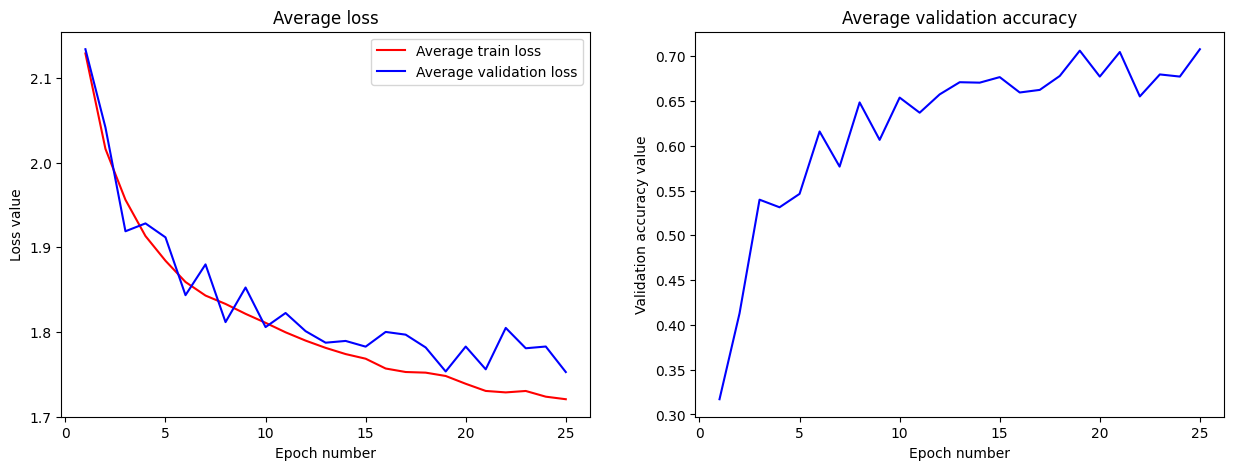

In [54]:
train_loss_arr = np.concatenate((train_loss_arr_pretr, wideresnet_nn_model_cycle.train_loss_arr))
val_loss_arr = np.concatenate((val_loss_arr_pretr, wideresnet_nn_model_cycle.val_loss_arr))
val_accuracy_arr = np.concatenate((val_accuracy_arr_pretr, wideresnet_nn_model_cycle.val_accuracy_arr))
# train_loss_arr = wideresnet_nn_model_cycle.train_loss_arr
# val_loss_arr = wideresnet_nn_model_cycle.val_loss_arr
# val_accuracy_arr = wideresnet_nn_model_cycle.val_accuracy_arr
ModelCycles.plot_loss_acc(25, train_loss_arr, val_loss_arr, val_accuracy_arr)

## Despite the fact that we got highest accuracy on the epoch 25, if we look at the graph we will see that our model definitely starts overfitting, because both validation plots have reached their plateu. As a result we will stop here.

In [55]:
# Save checkpoint
torch.save(wideresnet_nn.state_dict(), 'WideResNet_25epoch.pth')
# To load weigths:
# wideresnet_nn.load_state_dict(torch.load(path))
# wideresnet_nn.eval()
np.save('WideResNet_train_loss_arr_25.npy', train_loss_arr)
np.save('WideResNet_val_loss_arr_25.npy', val_loss_arr)
np.save('WideResNet_val_accuracy_arr_25.npy', val_accuracy_arr)

In [56]:
# wideresnet_nn = WideResNet(depth=28, widen_factor=10, dropout=0.3).to(device)
# wideresnet_nn.load_state_dict(torch.load('/kaggle/input/cv-tasks-lab3-data/WideResNet_25epoch.pth'))
# wideresnet_nn_model_cycle.model = wideresnet_nn
test_loss_score, test_accuracy_score = wideresnet_nn_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 1.7495750188827515
Test accuracy: 0.7097643613815308


# Conclusions
### The final results for three models trained on CIFAR10 datasets are as follows:
|   | Architecture    | Parameters                          | Number of epochs | Best model epoch | Test loss | Test accuracy |
|---|-----------------|-------------------------------------|------------------|------------------|-----------|---------------|
| 1 | AlexNet         | lr=0.001, momentum=0.9, dropout=0.5 | 140              | 140              | 1.7       | 76.12%        |
| 2 | Xception        | lr=0.001, momentum = 0.9            | 17               | 15               | 1.66928   | 79.73%        |
| 3 | WideResNet28-10 | lr=0.005, momentum=0.9, dropout=0.3 | 25               | 25               | 1.74958   | 70.98%        |
### As we see, for configurations used in this work it took Xception the least amount of epochs to get it's best result and it's accuracy on the test set is the biggest. Xception slightly outperformed AlexNet, although AlexNet outperformed WideResNet, despite the fact that in theory it shouldn't have happened. This could be due to the fact that I didn't use strong augmentation and weight decay (so initial learning rate is different as well) although authors in their article did. As we can also see from the results it takes much less epochs for Xception and WideResNet to reach decent results than AlexNet, possibly because of usage of residual connections and bigger complexity.